## This script is used for calculating the CovBox covariance 

In [57]:
import os
os.environ["MPICH_GPU_SUPPORT_ENABLED"] = "0"
import sys
import glob
import fitsio
import numpy as np
import matplotlib.pyplot as plt
from astropy.table import Table, vstack
from matplotlib.lines import Line2D
from matplotlib.ticker import ScalarFormatter, NullFormatter
plt.rcParams['axes.labelsize'] = 12
plt.rcParams['axes.titlesize'] = 12
plt.rcParams['legend.fontsize'] = 12
%config InlineBackend.figure_format = 'retina'
%matplotlib inline

from mockfactory import utils, DistanceToRedshift, Catalog, RandomBoxCatalog
from cosmoprimo.fiducial import DESI, AbacusSummit
from pycorr import TwoPointCorrelationFunction
from pycorr import project_to_multipoles, project_to_wp
from pypower import CatalogFFTPower, PowerSpectrumMultipoles, setup_logging
from pyrecon import MultiGridReconstruction, IterativeFFTReconstruction, IterativeFFTParticleReconstruction, utils, setup_logging

In [58]:
sys.path.append('/global/homes/s/shengyu/project_rc/main/Y3/')
from helper import REDSHIFT_VSMEAR, REDSHIFT_CUBICBOX, EDGES, GET_RECON_BIAS
from helper import REDSHIFT_LSS_VSMEAR, REDSHIFT_LSS_CUBICBOX, REDSHIFT_LSS_EZMOCKS, EDGES, GET_RECON_BIAS
from fit_cubic_tools import load_bins, load_rescalc_cov
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [59]:
# basic settings
kedges   = np.arange(0.,0.4001,0.001); ells = (0, 2)
smuedges  = (np.linspace(0., 200, 201), np.linspace(-1., 1., 201))
slogmuedges= (np.geomspace(0.01, 100., 100), np.linspace(-1., 1., 201))
rplogedges = (np.geomspace(0.01, 100., 100), np.linspace(-1., 1., 201))

In [81]:
tracer = 'ELG'
z = 0
z_cubic = REDSHIFT_LSS_EZMOCKS[tracer][z]
(zmin, zmax) = REDSHIFT_LSS_VSMEAR[tracer][z]
mock_id  = 1
mock_id04 =  f"{mock_id:04}"

if tracer in ['BGS']:
    boxsize  = 500.
    base_dir = '/global/cfs/cdirs/desicollab/cosmosim/SecondGenMocks/EZmock/CubicBox_2Gpc' 
if tracer in ['LRG','ELG','QSO']:
    boxsize  = 1500.
    base_dir = '/global/cfs/cdirs/desicollab/cosmosim/SecondGenMocks/EZmock/CubicBox_6Gpc'
mock_fn = base_dir+f'/{tracer}/z{z_cubic:.3f}/{mock_id04}/EZmock_{tracer}_z{z_cubic:.3f}_AbacusSummit_base_c000_ph000_{mock_id04}.0.fits.gz'
catalog = Catalog.read(mock_fn, filetype='fits')

In [82]:
print(max(catalog['x']),min(catalog['x']))
print(max(catalog['y']),min(catalog['y']))
print(max(catalog['z']),min(catalog['z']))

1499.9999 0.00020064019
1499.9999 0.00033504007
1499.9999 0.00026898005


In [83]:
print(tracer, z_cubic, (zmin, zmax))

ELG 0.95 (0.8, 1.1)


In [ ]:
# in redshift space, assuming los = 'z'
cosmo = DESI()
zmid = (zmin+zmax)/2
Hz = cosmo.H0*cosmo.efunc(zmid)
x = catalog['x']
y = catalog['y']
z = catalog['z']+catalog['vz']*(1+zmid)/Hz
data_positions = [x,y,z]
(rmin, rmax, rbin, lenr) = load_bins('xi', 'test')
result_mps = TwoPointCorrelationFunction('smu', smuedges, data_positions1=data_positions, 
                                            engine='corrfunc', boxsize=boxsize, 
                                            los='z', position_type='xyz', nthreads = 4)
result = result_mps[::rbin,::]
result.select((rmin, rmax))
r, xi = project_to_multipoles(result, ells=[0,2])

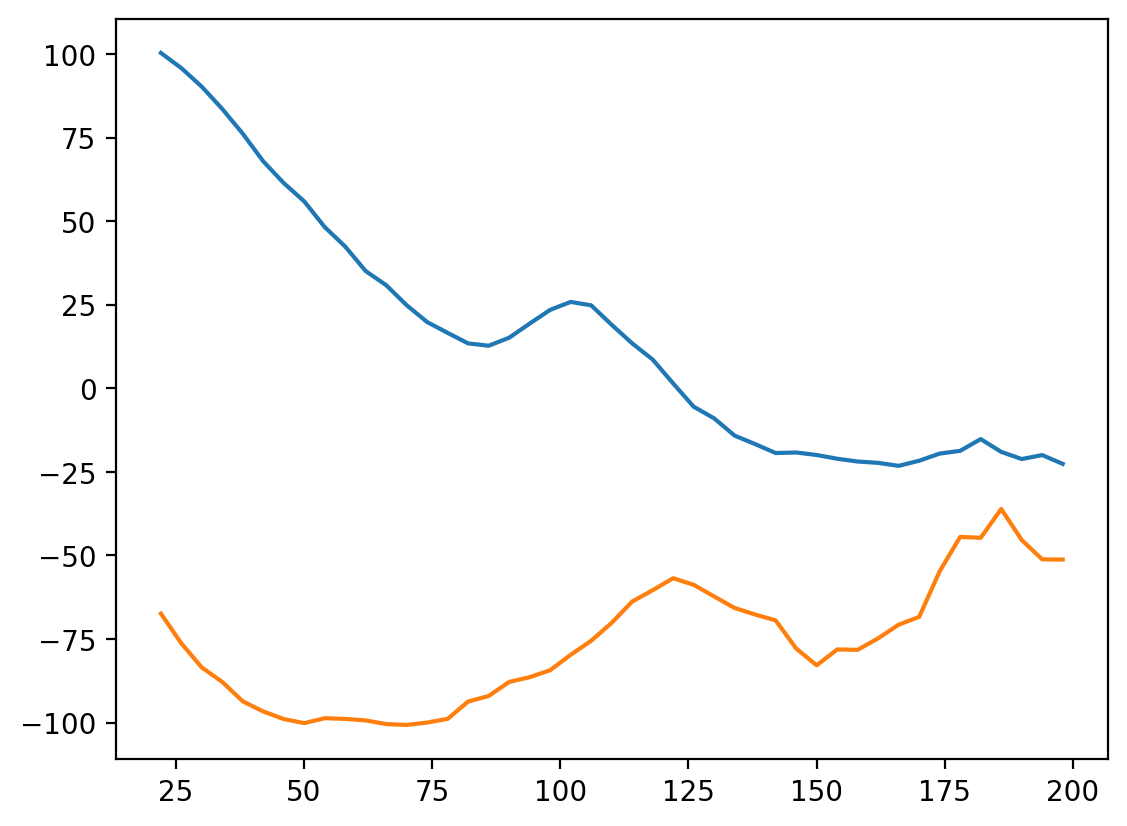

In [75]:
plt.plot(r, r**2*xi[0])
plt.plot(r, r**2*xi[1])

In [ ]:
sysmodel = 'standard'
base_dir = '/pscratch/sd/s/shengyu/galaxies/catalogs/cosmosim/EZmocks'
save_dir = base_dir+f'/{tracer}/z{z_cubic:.3f}/{mock_id04}'
save_fn = save_dir+f'/mpspk/{{}}_{tracer}_z{zmin:.1f}-{zmax:.1f}_{sysmodel}.npy'

In [ ]:
setup_logging()
tracer = 'BGS'
z_cubic = REDSHIFT_CUBICBOX[tracer][0]
(zmin, zmax) = REDSHIFT_VSMEAR[tracer][0]

base_dir = '/pscratch/sd/s/shengyu/galaxies/catalogs/cosmosim/AbacusHOD_mocks_v1/CubicBox/BGS/z0.200/AbacusSummit_base_c000_ph000'
catalog_fn = base_dir+'/BGS_box_ph000.fits'
catalog = Catalog.read(catalog_fn, filetype='fits')
catalog = catalog[catalog['R_MAG_ABS'] < -21.5]

In [45]:
# in redshift space, assuming los = 'z'
cosmo = DESI()
zmid = (zmin+zmax)/2
Hz = cosmo.H0*cosmo.efunc(zmid)
x = catalog['x']
y = catalog['y']
z = catalog['z']+catalog['vz']*(1+zmid)/Hz
data_positions = [x,y,z]

[000175.05]  03-10 03:48  TwoPointCorrelationFunction  INFO     Using estimator <class 'pycorr.twopoint_estimator.NaturalTwoPointEstimator'>.
[000175.05]  03-10 03:48  TwoPointCorrelationFunction  INFO     Running auto-correlation.
[000175.05]  03-10 03:48  TwoPointCorrelationFunction  INFO     Computing two-point counts D1D2.


[000288.59]  03-10 03:50  TwoPointCorrelationFunction  INFO     Analytically computing two-point counts R1R2.
[000288.59]  03-10 03:50  TwoPointCorrelationFunction  INFO     Correlation function computed in elapsed time 113.55 s.


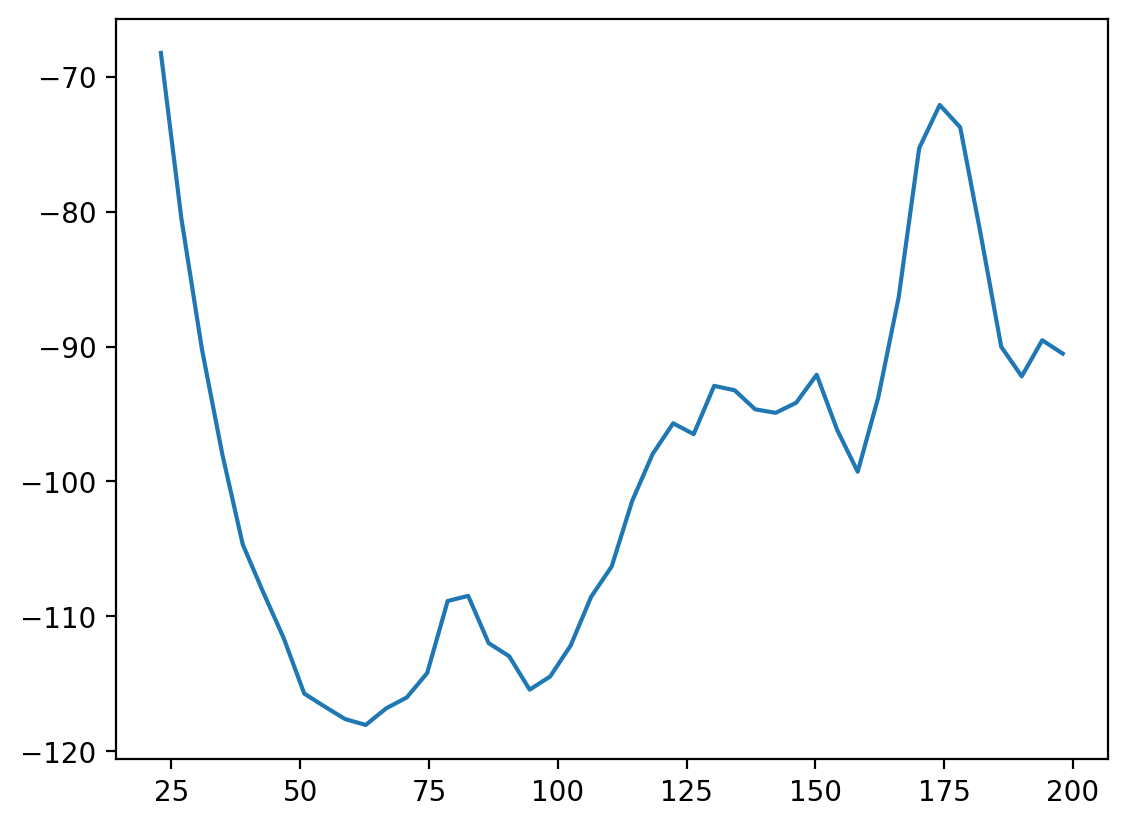

In [46]:
for los in ['z']:
    (rmin, rmax, rbin, lenr) = load_bins('xi', 'test')
    smuedges  = (np.linspace(1., 200, 201), np.linspace(-1., 1., 201))
    result_mps = TwoPointCorrelationFunction('smu', smuedges, data_positions1=data_positions, 
                                                engine='corrfunc', 
                                                boxsize=2000., los=los, position_type='xyz', nthreads = 4)
    result = result_mps[::rbin,::]
    result.select((rmin, rmax))
    r, xi = project_to_multipoles(result, ells=[0,2])
    plt.plot(r, r**2*xi[1])

In [ ]:
catalog_fn = '/pscratch/sd/s/shengyu/galaxies/catalogs/cosmosim/AbacusHOD_mocks_v1/CubicBox/BGS/obs_z0.1-0.4/AbacusSummit_base_c000_ph000/catalog_rsd_BGS_z0.1-0.4.fits'
catalog = Catalog.read(catalog_fn, filetype='fits')
(rmin, rmax, rbin, lenr) = load_bins('xi', 'test')
smuedges  = (np.linspace(1., 200, 201), np.linspace(-1., 1., 201))
result_mps = TwoPointCorrelationFunction('smu', smuedges, data_positions1=[catalog['x'],catalog['y'],catalog['z']], 
                                            engine='corrfunc', 
                                            boxsize=2000., los='z', position_type='xyz', nthreads = 4)
result = result_mps[::rbin,::]
result.select((rmin, rmax))
r, xi = project_to_multipoles(result, ells=[0,2])
plt.plot(r, r**2*xi[1])


4309368


In [ ]:
tracer = 'ELG'
# z_cubic = 0.5
boxsize = 500.
setup_logging()
# i = 0
mockids = np.arange(3000,4500)
for z_cubic, (zmin, zmax) in zip(REDSHIFT_CUBICBOX[tracer], REDSHIFT_VSMEAR[tracer]):
    for mock_id in mockids:
        mock_id04 =  f"{mock_id:04}"
        cov_dir = f'/global/cfs/cdirs/desi/cosmosim/AbacusHOD_mocks/v1/CovBox/{tracer}/z{z_cubic:.3f}'
        if tracer == 'LRG':
            catalog_fn = cov_dir + f'/catalog_rsd_xi2d_{tracer.lower()}_main_z{z_cubic:.1f}_velbias_mockcov_ph{mock_id04}.fits'
        elif tracer == 'ELG':
            catalog_fn = cov_dir + f'/catalog_rsd_xi2d_{tracer.lower()}_z{z_cubic:.1f}_velbias_B_mockcov_ph{mock_id04}.fits'
        elif tracer == 'QSO':
            catalog_fn = cov_dir + f'/catalog_rsd_xi2d_{tracer.lower()}_z{z_cubic:.1f}_velbias_B_mockcov_zerr_skip5_ph{mock_id04}.fits'
        if not os.path.isfile(catalog_fn):
            print(f"File not found: {catalog_fn}. Skipping mock_id={mock_id04}",flush=True)
            # skip_ids.append(mock_id04)
            continue
        # catalog=Table(fitsio.read(catalog_fn))
        # compute mps
        fn_mps = f'/pscratch/sd/s/shengyu/galaxies/catalogs/cosmosim/AbacusHOD_mocks_v1/CovBox/{tracer}/z{z_cubic:.3f}/xi/{{}}_{tracer}_z{z_cubic:.1f}_ph{mock_id04}.npy'.format('xipoles')
        if not os.path.exists(fn_mps):
            print(f"Loading {catalog_fn}")
            data = Catalog.read(catalog_fn)
            data_positions = np.array([data['x'],data['y'], data['z']])
            smuedges  = (np.linspace(1., 200, 201), np.linspace(-1., 1., 201))
            result_mps = TwoPointCorrelationFunction('smu', smuedges, data_positions1=data_positions, 
                                                        engine='corrfunc', 
                                                        boxsize=boxsize, los='z', position_type='xyz',
                                                        gpu=True, nthreads = 4)
                                                    #  mpiroot=mpiroot, mpicomm=mpicomm)
            result_mps.save(fn_mps)
        # compute pk
        fn_pk = f'/pscratch/sd/s/shengyu/galaxies/catalogs/cosmosim/AbacusHOD_mocks_v1/CovBox/{tracer}/z{z_cubic:.3f}/pk/{{}}_{tracer}_z{z_cubic:.1f}_ph{mock_id04}.npy'.format('pkpoles')
        if not os.path.exists(fn_pk):
            print(f"Loading {catalog_fn}")
            data = Catalog.read(catalog_fn)
            data_positions = np.array([data['x'],data['y'], data['z']])
            kedges   = np.arange(0.,0.4001,0.001); ells = (0, 2)
            result_pk = CatalogFFTPower(data_positions1=data_positions, 
                                        edges=kedges, ells=ells, interlacing=3, 
                                        boxsize=boxsize, nmesh=512, resampler='tsc',los='z', position_type='xyz',)
                                        # mpiroot=mpiroot, mpicomm=mpicomm)
            result_pk.save(fn_pk)

File not found: /global/cfs/cdirs/desi/cosmosim/AbacusHOD_mocks/v1/CovBox/QSO/z0.800/catalog_rsd_xi2d_qso_z0.8_velbias_B_mockcov_zerr_skip5_ph3008.fits. Skipping mock_id=3008
File not found: /global/cfs/cdirs/desi/cosmosim/AbacusHOD_mocks/v1/CovBox/QSO/z0.800/catalog_rsd_xi2d_qso_z0.8_velbias_B_mockcov_zerr_skip5_ph3010.fits. Skipping mock_id=3010
File not found: /global/cfs/cdirs/desi/cosmosim/AbacusHOD_mocks/v1/CovBox/QSO/z0.800/catalog_rsd_xi2d_qso_z0.8_velbias_B_mockcov_zerr_skip5_ph3024.fits. Skipping mock_id=3024
File not found: /global/cfs/cdirs/desi/cosmosim/AbacusHOD_mocks/v1/CovBox/QSO/z0.800/catalog_rsd_xi2d_qso_z0.8_velbias_B_mockcov_zerr_skip5_ph3037.fits. Skipping mock_id=3037
File not found: /global/cfs/cdirs/desi/cosmosim/AbacusHOD_mocks/v1/CovBox/QSO/z0.800/catalog_rsd_xi2d_qso_z0.8_velbias_B_mockcov_zerr_skip5_ph3048.fits. Skipping mock_id=3048
File not found: /global/cfs/cdirs/desi/cosmosim/AbacusHOD_mocks/v1/CovBox/QSO/z0.800/catalog_rsd_xi2d_qso_z0.8_velbias_B_mock

KeyboardInterrupt: 